# A thalamo-cortical model of post-sleep memory improvement

*Bruna, Catalina and Flávio.*

LASCON 2024

In this Jupyter Notebook, we are going to model a thalamo-cortical model of post-sleep memory improvement. This project reproduces the paper ["Sleep-like slow oscillations improve visual classification through synaptic homeostasis and memory association in a thalamo-cortical model"](https://www.nature.com/articles/s41598-019-45525-0) (Capone, C., Pastorelli, E., Golosio, B. et al. 2019), whose code is not publicly available. The project is also part of the activities developed during LASCON 2024. 

In this notebook, we will go step by step in the simulation of the phases:

1. Get MNIST dataset
2. Training phase
3. Pre-sleep retrieval phase
4. Sleep phase
5. Post-sleep retrieval phase

You can find model creatin details in network.py file.

Let's start. :)

-------------------------------

Importing libraries

In [1]:
import nest
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from model.network import Network
from dataset.dataclass import MNIST


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.4
 Built: Jul 22 2023 00:00:00

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## 1. Get MNIST dataset

To save up time, we are using downloade data generated from the dataclass.py file. If you want to generate in this notebook, do the following:

- Process data: Ex.: x_train_feat_vector = data.process_and_store(data.x_train)

This might take up 5 minutes. 

In [2]:
# Instantiate constructor
data = MNIST()

From the MNIST dataset, let's now get three times the number 0, 1, and 2, totaling nine images

In [3]:
# Find indices of the n first occurrences of 0, 1, and 2
n_first_occurr = 3

zero_indices = np.where(data.y_train == 0)[0][:n_first_occurr]
one_indices = np.where(data.y_train == 1)[0][:n_first_occurr]
two_indices = np.where(data.y_train == 2)[0][:n_first_occurr]

print("First three 0 occurrences:", zero_indices)
print("First three 1 occurrences:", one_indices)
print("First three 2 occurrences:", two_indices)

First three 0 occurrences: [ 1 21 34]
First three 1 occurrences: [3 6 8]
First three 2 occurrences: [ 5 16 25]


Then, we have our total n of training images = 9.

Let's generate the list we are going to input to the tc population.

In [4]:
# Combine the indices for 0, 1, and 2
all_indices = [zero_indices, one_indices, two_indices]

# Flatten the list of numpy arrays indices
flat_indices = [item for sublist in all_indices for item in sublist]

# Create an empty list to store the result
train_feat_vect = []

# Transform data feature vector into list
x_train_feat_vectors = data.x_train_feat_vect.tolist()

# Loop through each set of indices and append corresponding feature vectors
for index in flat_indices:
    feat_vector = x_train_feat_vectors[index]
    train_feat_vect.append(feat_vector)

## 2. Training phase

*"Every time a new training image is presented to the network through the thalamic pathway, the facilitation signal coming from the contextual signal provides a 2 kHz Poisson spike train to a different set of 20 neurons, inducing the group to encode for that specific input stimulus (see the Discussion section for details about this choice). Additionally a 10 kHz Poisson spike train is provided to inhibitory neurons (in) to prevent already trained neurons to respond to new stimuli in the training phase."* (Capone, C., Pastorelli, E., Golosio, B. et al. 2019)

First, let's instantiate the network and connect it to the multimeters and spike recorders.

In [5]:
# Instantiate network
net = Network(n_train_images=9)

In [6]:
# Connect to multimeters and spike records
net.connect_all_devices()

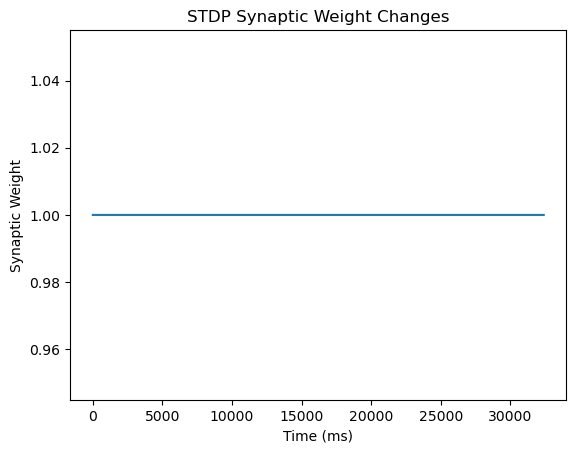

In [7]:
# Get connections
wr_cxcx = nest.GetConnections(net.cx_pop, net.cx_pop)

# Extract data
weights = wr_cxcx.get('weight')

# Plot the results
plt.plot(weights)
plt.xlabel("Time (ms)")
plt.ylabel("Synaptic Weight")
plt.title("STDP Synaptic Weight Changes")
plt.show()

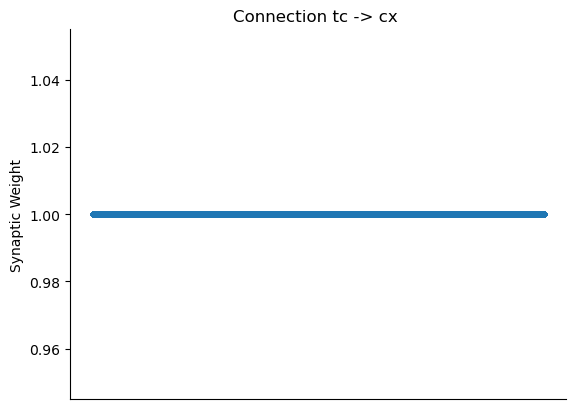

In [8]:
# Get connections
wr_cxcx = nest.GetConnections(net.tc_pop, net.cx_pop)

# Extract data
weights = wr_cxcx.get('weight')

# Plot the results
plt.plot(weights, '.')
plt.title('Connection tc -> cx ')
plt.ylabel("Synaptic Weight")
plt.xticks([])

sns.despine()
plt.show()

Run simulation.

In [9]:
# The inhibitory signal in commented, even though it should be present, to reproduce the first figure of the paper. 

for i in range(0, net.n_train_images):
    if i == 0:
        net.input_train_signal(time_id=i, feature_vector=train_feat_vect[i])
        net.input_context_signal(neuron_group=i)
        print(f"Run {i}.")
        nest.Simulate(900.0)
    else:
        net.input_train_signal(time_id=i, feature_vector=train_feat_vect[i])
        net.input_context_signal(neuron_group=i)
        #net.input_inhib_signal(time_id=i)
        print(f"Run {i}.")
        nest.Simulate(900.0)

Training signal successfully created.
Connecting input to the tc population...

Feb 01 17:43:06 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.
... training signal successfully connected to the tc population.
Contextual signal successfully created.
Connecting input to the cx population...
... contextual signal successfully connected to the cx population.
Run 0.

Feb 01 17:43:06 NodeManager::prepare_nodes [Info]: 
    Preparing 917 nodes for simulation.
Training signal successfully created.
Connecting input to the tc population...

Feb 01 17:43:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 917
    Simulation time (ms): 900
    Number of OpenMP threads: 1
    Not using MPI

Feb 01 17:43:24 SimulationManager::run [Info]: 
    Simulation finished.
... training signal successfully connected to the tc population.
Contextual signal successfully created.
Connecting inp

Plot results.

Cx population:

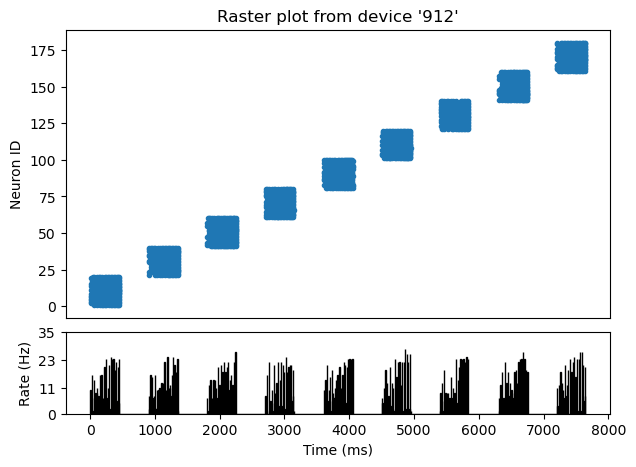

In [10]:
nest.raster_plot.from_device(net.spikes_cx, hist=True)

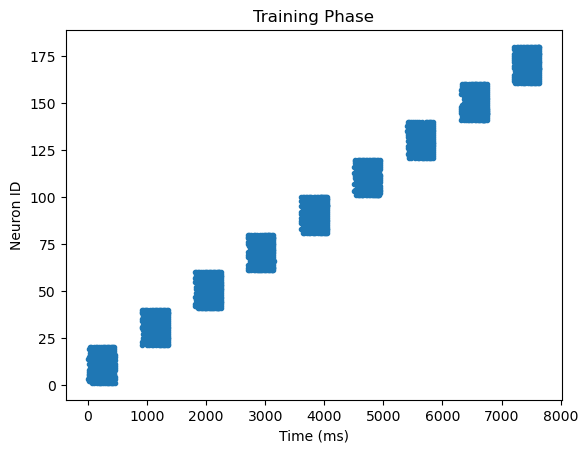

In [11]:
nest.raster_plot.from_device(net.spikes_cx, hist=False, title="Training Phase")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


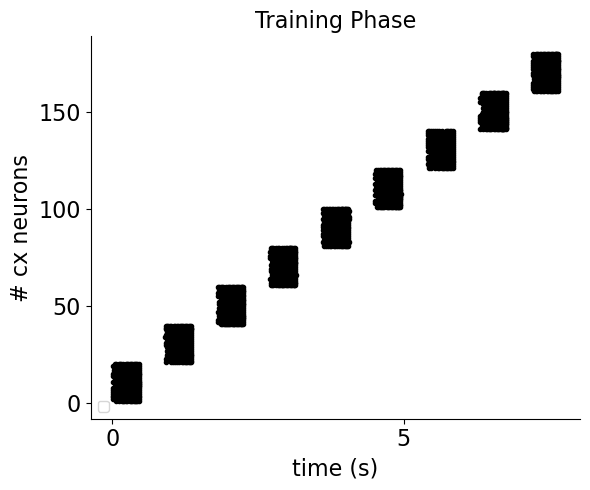

In [12]:
# Plot on my own

# Get events from spike recorder
cx_spike = net.spikes_cx.get("events")
send_cx = cx_spike["senders"]
ts_spike_cx = cx_spike["times"]

# Plot results

# Create a subplot with 1 row and 2 columns
plt.figure(figsize=(6,5))
plt.plot(ts_spike_cx, send_cx, 'k.')
plt.title('Training Phase', size=16)
plt.legend(loc=3)
plt.xlabel("time (s)", size=16)
plt.xticks([0, 5000],labels=[0, 5], fontsize=16)
plt.yticks([0, 50, 100, 150], fontsize=16)
plt.ylabel("# cx neurons", size=16)

# Adjust layout for better spacing
plt.tight_layout()

# Show the subplot
sns.despine()
plt.show()

Tc population:

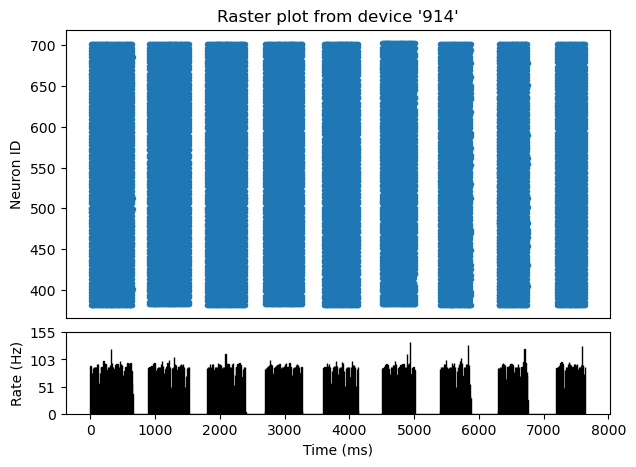

In [13]:
nest.raster_plot.from_device(net.spikes_tc, hist=True)

In [14]:
# Get events from multimeter
tc_vm = net.mult_tc.get()
vm_tc = tc_vm["events"]["V_m"]
ts_vm_tc = tc_vm["events"]["times"]

# Get events from spike recorder
tc_spike = net.spikes_tc.get("events")
send_tc = tc_spike["senders"]
ts_spike_tc = tc_spike["times"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


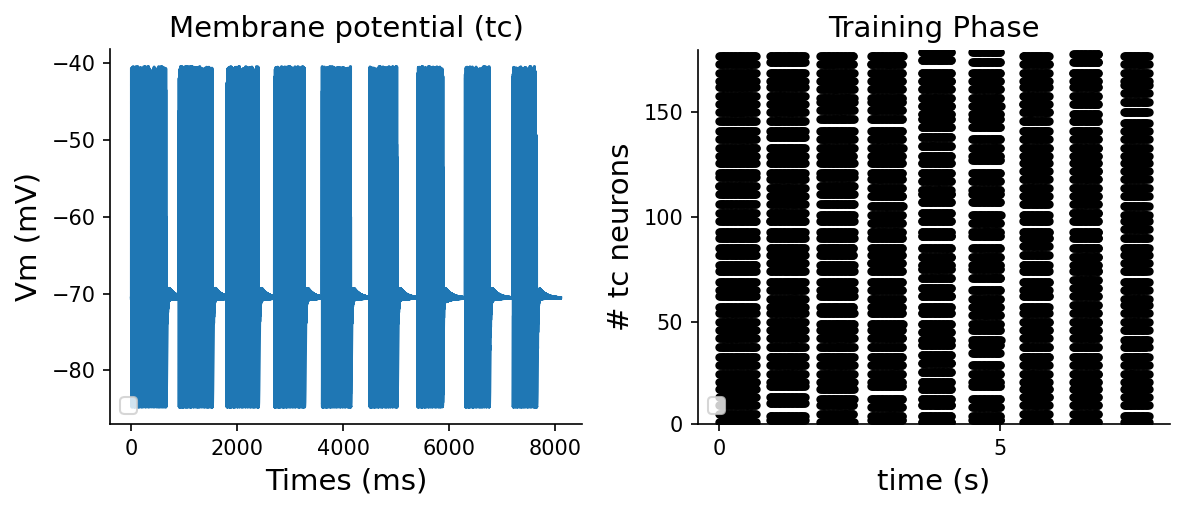

In [15]:
# Plot results

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, dpi=150, figsize=(8, 3.5), sharey=False)

axs[0].plot(ts_vm_tc, vm_tc)
axs[0].set_title('Membrane potential (tc)', size=14)
axs[0].legend(loc=3)
axs[0].set_xlabel("Times (ms)", size=14)
axs[0].set_ylabel("Vm (mV)", size=14)  # Fixed the ylabel, and "mV" is commonly used for millivolts

axs[1].plot(ts_spike_tc, send_tc, 'k.')
axs[1].set_title('Training Phase', size=14)
axs[1].legend(loc=3)
axs[1].set_xlabel("time (s)", size=14)
axs[1].set_ylim([381, 560])
axs[1].set_xticks([0, 5000,])
axs[1].set_xticklabels(labels=[0, 5])
axs[1].set_yticks([381, 430, 480, 530])
axs[1].set_yticklabels(labels=[0, 50, 100, 150])
axs[1].set_ylabel("# tc neurons", size=14)

# Adjust layout for better spacing
plt.tight_layout()

# Show the subplot
sns.despine()
plt.show()

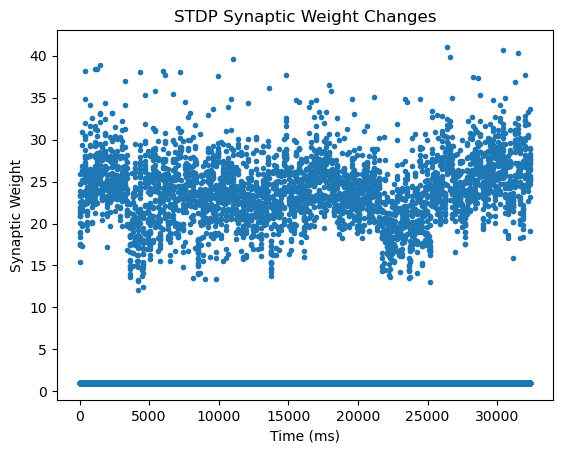

In [16]:
# Get connections
wr_cxcx = nest.GetConnections(net.cx_pop, net.cx_pop)

# Extract data
weights = wr_cxcx.get('weight')

# Plot the results
plt.plot(weights, '.')
plt.xlabel("Time (ms)")
plt.ylabel("Synaptic Weight")
plt.title("STDP Synaptic Weight Changes")
plt.show()

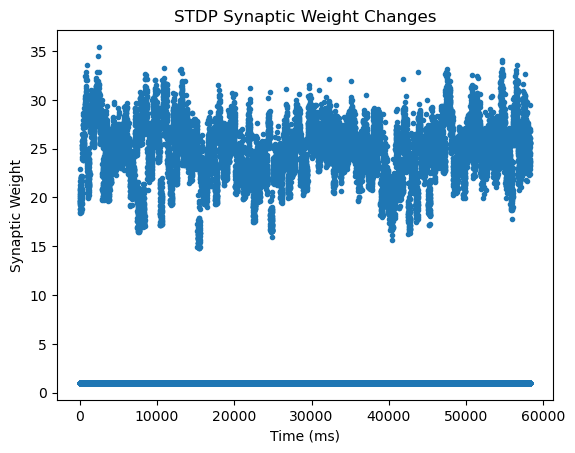

In [17]:
# Get connections
wr_cxtc = nest.GetConnections(net.cx_pop, net.tc_pop)

# Extract data
weights = wr_cxtc.get('weight')

# Plot the results
plt.plot(weights, '.')
plt.xlabel("Time (ms)")
plt.ylabel("Synaptic Weight")
plt.title("STDP Synaptic Weight Changes")
plt.show()

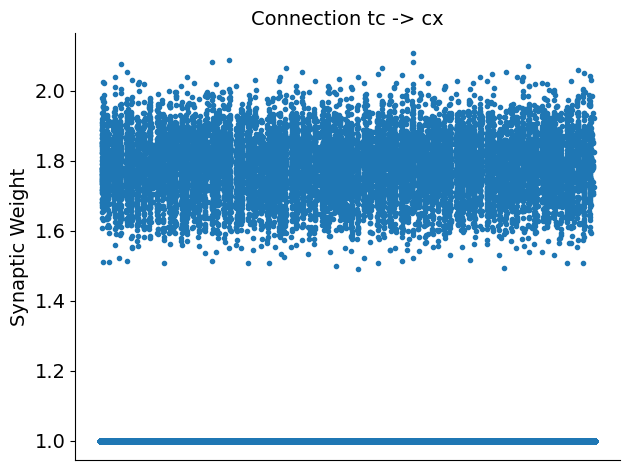

In [18]:
# Get connections
wr_tccx = nest.GetConnections(net.tc_pop, net.cx_pop)

# Extract data
weights = wr_tccx.get('weight')

# Plot the results
plt.plot(weights, '.')
plt.ylabel("Synaptic Weight", fontsize=14)
plt.title("Connection tc -> cx", fontsize=14)
plt.xticks([])
plt.yticks(fontsize=14)

plt.tight_layout()
sns.despine()
plt.show()

In population:

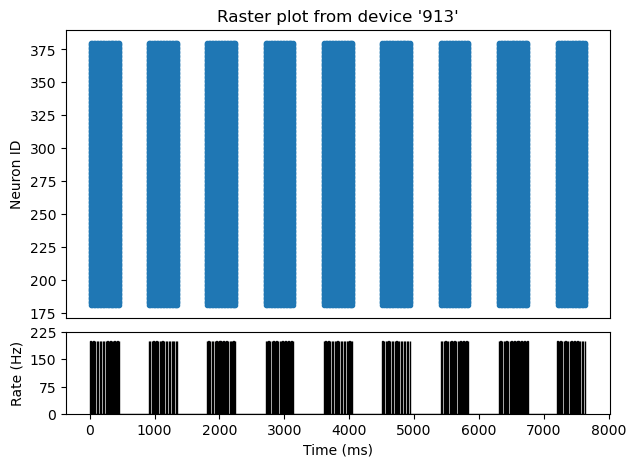

In [19]:
nest.raster_plot.from_device(net.spikes_in, hist=True)

Re population:

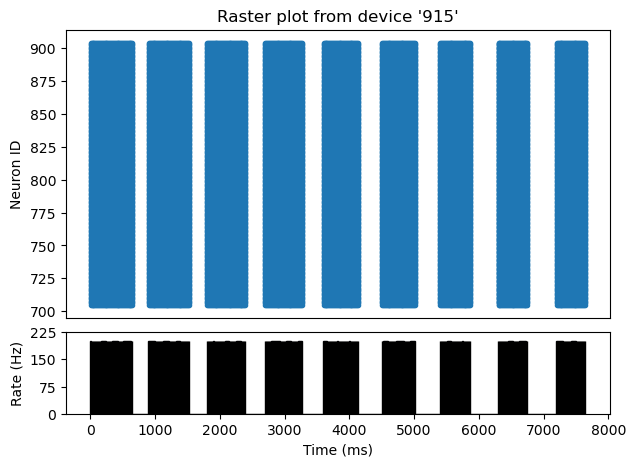

In [20]:
nest.raster_plot.from_device(net.spikes_re, hist=True)

## 3. Pre-sleep retrieval phase

*"During the retrieval phase only the 30 kHz input to thalamic cell is provided, while the contextual signal is off."* (Capone, C., Pastorelli, E., Golosio, B. et al. 2019)

Run simulation.

In [21]:
# Simulate for all populations

for i in range(net.n_train_images):
    net.input_train_signal(time_id=(i + net.n_train_images), feature_vector=train_feat_vect[i])
    print(f"Run {i}.")
    nest.Simulate(900.0)

Training signal successfully created.
Connecting input to the tc population...

Feb 01 17:46:07 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.
... training signal successfully connected to the tc population.
Run 0.
Training signal successfully created.
Connecting input to the tc population...

Feb 01 17:46:07 NodeManager::prepare_nodes [Info]: 
    Preparing 934 nodes for simulation.

Feb 01 17:46:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 934
    Simulation time (ms): 900
    Number of OpenMP threads: 1
    Not using MPI

Feb 01 17:46:18 SimulationManager::run [Info]: 
    Simulation finished.
... training signal successfully connected to the tc population.
Run 1.
Training signal successfully created.
Feb 01 17:46:18 NodeManager::prepare_nodes [Info]: 
    Preparing 935 nodes for simulation.

Feb 01 17:46:18 SimulationManager::start_updating_ [Info]: 
    

Plot results.

Cx population:

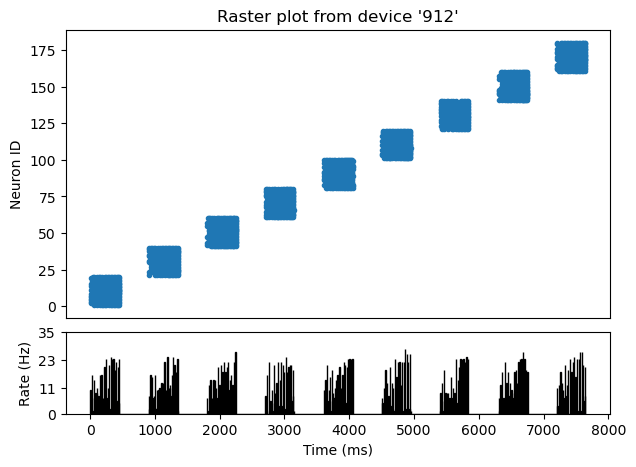

In [22]:
nest.raster_plot.from_device(net.spikes_cx, hist=True)

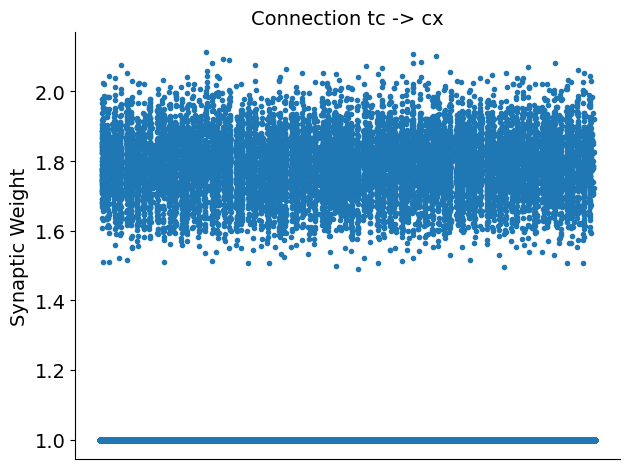

In [23]:
# Get connections
wr_tccx = nest.GetConnections(net.tc_pop, net.cx_pop)

# Extract data
weights = wr_tccx.get('weight')

# Plot the results
plt.plot(weights, '.')
plt.ylabel("Synaptic Weight", fontsize=14)
plt.title("Connection tc -> cx", fontsize=14)
plt.xticks([])
plt.yticks(fontsize=14)

plt.tight_layout()
sns.despine()
plt.show()

[[<matplotlib.lines.Line2D at 0x7f1e5541e810>],

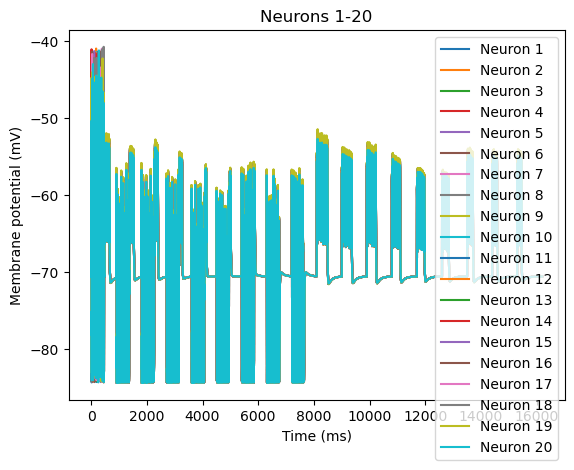

In [24]:
nest.voltage_trace.from_device(net.mult_cx, list(range(1, 21)), title="Neurons 1-20")

In [25]:
help(nest.voltage_trace.from_device)

Help on function from_device in module nest.voltage_trace:

from_device(detec, neurons=None, title=None, grayscale=False, timeunit='ms')
    Plot the membrane potential of a set of neurons recorded by
    the given voltmeter or multimeter.

    Parameters
    ----------
    detec : list
        Global id of voltmeter or multimeter in a list, e.g. [1]
    neurons : list, optional
        Indices of of neurons to plot
    title : str, optional
        Plot title
    grayscale : bool, optional
        Plot in grayscale
    timeunit : str, optional
        Unit of time

    Raises
    ------
    nest.kernel.NESTError
        Description



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


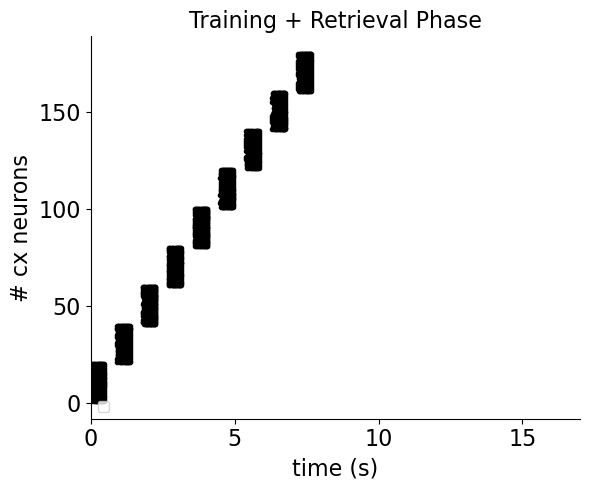

In [26]:
# Plot on my own

# Get events from spike recorder
cx_spike = net.spikes_cx.get("events")
send_cx = cx_spike["senders"]
ts_spike_cx = cx_spike["times"]

# Plot results

# Create a subplot with 1 row and 2 columns
plt.figure(figsize=(6,5))
plt.plot(ts_spike_cx, send_cx, 'k.')
plt.title('Training + Retrieval Phase', size=16)
plt.legend(loc=3)
plt.xlabel("time (s)", size=16)
plt.xlim([8000, 17000])
plt.xticks([0, 5000, 10000, 15000],labels=[0, 5, 10, 15], fontsize=16)
plt.yticks([0, 50, 100, 150], fontsize=16)
plt.ylabel("# cx neurons", size=16)

# Adjust layout for better spacing
plt.tight_layout()

# Show the subplot
sns.despine()
plt.show()

Tc population:

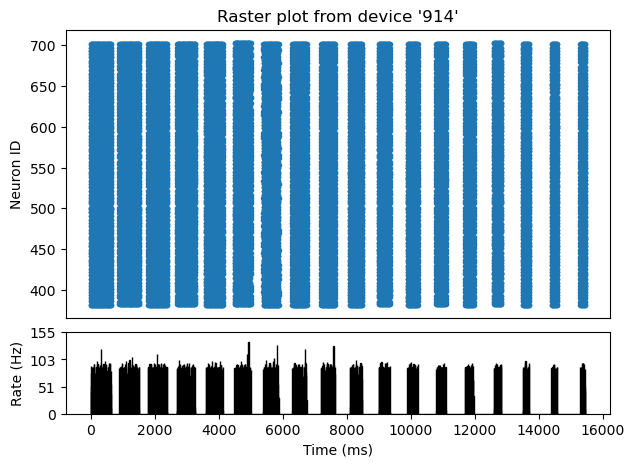

In [27]:
nest.raster_plot.from_device(net.spikes_tc, hist=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


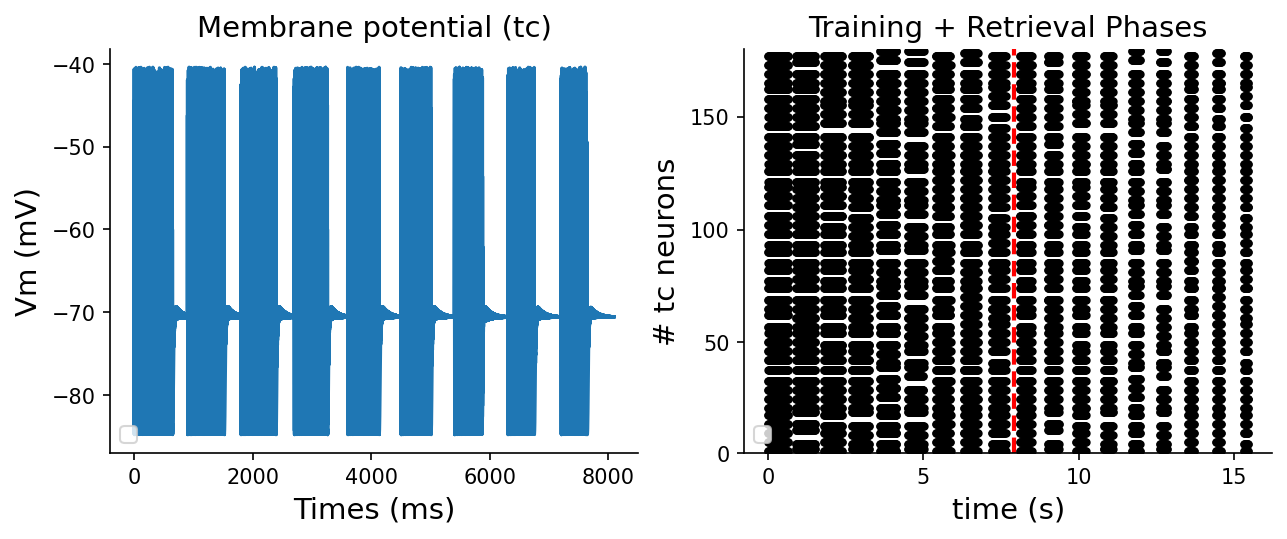

<Figure size 640x480 with 0 Axes>

In [62]:
# Plot on my own

# Get events from spike recorder
tc_spike = net.spikes_tc.get("events")
send_tc = tc_spike["senders"]
ts_spike_tc = tc_spike["times"]

# Plot results

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, dpi=150, figsize=(10, 3.5), sharey=False)

axs[0].plot(ts_vm_tc, vm_tc)
axs[0].set_title('Membrane potential (tc)', size=14)
axs[0].legend(loc=3)
axs[0].set_xlabel("Times (ms)", size=14)
axs[0].set_ylabel("Vm (mV)", size=14)  # Fixed the ylabel, and "mV" is commonly used for millivolts

axs[1].plot(ts_spike_tc, send_tc, 'k.')
axs[1].set_title('Training + Retrieval Phases', size=14)
axs[1].legend(loc=3)
axs[1].set_xlabel("time (s)", size=14)
#axs[1].set_xlim([8000, 17000])
axs[1].set_ylim([381, 560])
axs[1].set_xticks([0, 5000, 10000, 15000])
axs[1].set_xticklabels(labels=[0, 5, 10, 15])
axs[1].set_yticks([381, 430, 480, 530])
axs[1].set_yticklabels(labels=[0, 50, 100, 150])
axs[1].set_ylabel("# tc neurons", size=14)

# Add dashed lines
dash_positions = [7900]  # Adjust these positions based on your requirements
for pos in dash_positions:
    plt.axvline(x=pos, color='red', linestyle='--', linewidth=2)

sns.despine()
plt.show()

# Adjust layout for better spacing
plt.tight_layout()

# Show the subplot
sns.despine()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


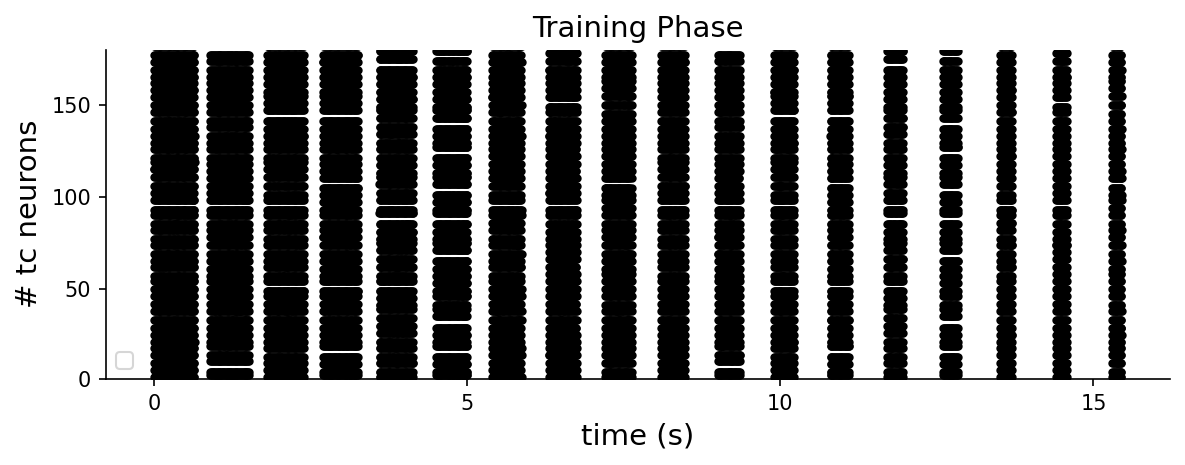

In [29]:
# Plot on my own

# Get events from spike recorder
tc_spike = net.spikes_tc.get("events")
send_tc = tc_spike["senders"]
ts_spike_tc = tc_spike["times"]

# Plot results

# Create a subplot with 1 row and 2 columns
plt.figure(dpi=150, figsize=(8, 3.2))
plt.plot(ts_spike_tc, send_tc, 'k.')
plt.title('Training Phase', size=14)
plt.legend(loc=3)
plt.xlabel("time (s)", size=14)
#axs[1].set_xlim([8000, 17000])
plt.ylim([381, 560])
plt.xticks([0, 5000, 10000, 15000], labels=[0, 5, 10, 15])
plt.yticks([381, 430, 480, 530], labels=[0, 50, 100, 150])
plt.ylabel("# tc neurons", size=14)

# Adjust layout for better spacing
plt.tight_layout()

# Show the subplot
sns.despine()
plt.show()

In population:

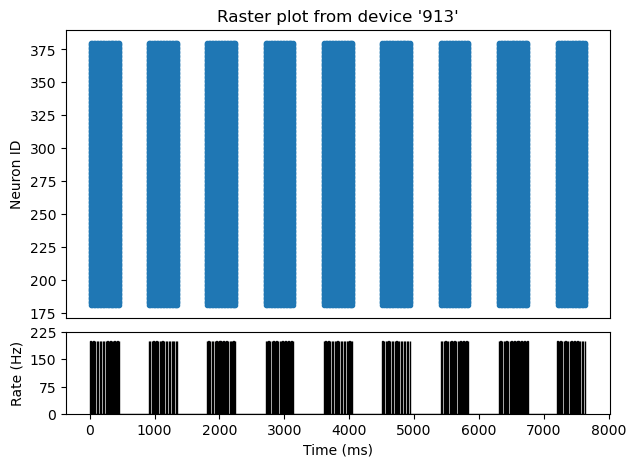

In [30]:
nest.raster_plot.from_device(net.spikes_in, hist=True)

Re population:

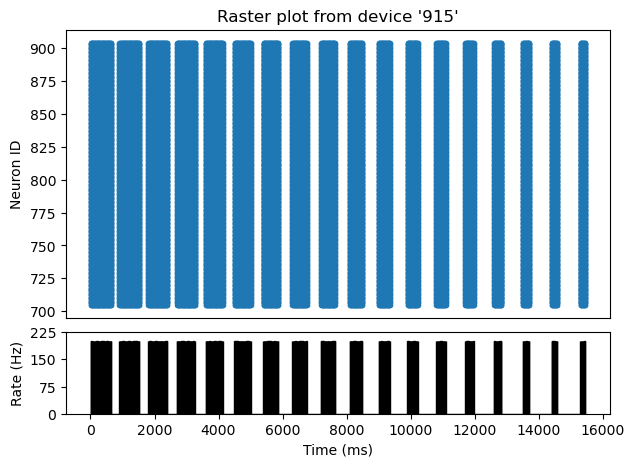

In [31]:
nest.raster_plot.from_device(net.spikes_re, hist=True)

### 3.1. Plot connection matrix of cx-cx synapses

In [32]:
# Get connections
conns = nest.GetConnections(net.cx_pop, net.cx_pop)

# Extract data
conn_dict = conns.get(['source', 'target', 'weight'])

# Initialize connection matrix
conn_matrix = np.zeros((180, 180))

# Iterate through the sources and targets, and set the corresponding weight in the matrix
for source, target, weight in zip(conn_dict.get('source'), conn_dict.get('target'), conn_dict.get('weight')):
    i_source = source -1
    i_target = target - 1
    conn_matrix[i_source, i_target] = weight

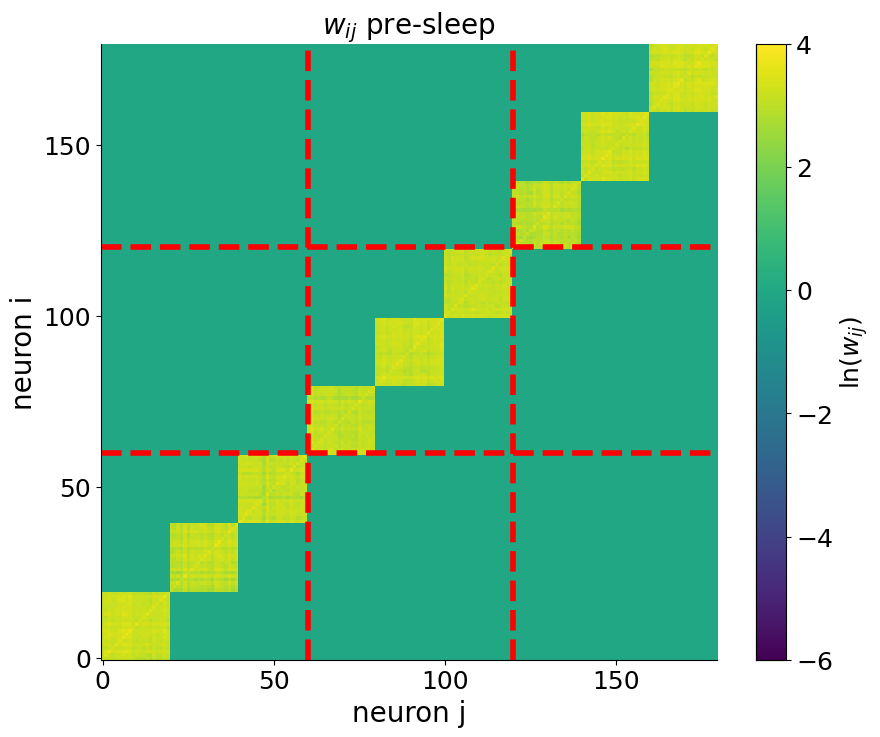

In [46]:
# Calculate the ln of the values within the conn_matrix
ln_matrix = np.log(conn_matrix)

# Set the limits of the colobar
min = -6
max = 4

# Plot the connection matrix

# Set the figure size
fig, ax = plt.subplots(figsize=(10, 8))

img = plt.imshow(ln_matrix, cmap='viridis', interpolation='nearest', origin='lower')
ax.set_title(r'$w_{ij}$ pre-sleep', fontsize=20)
ax.set_xlabel('neuron j', fontsize=20)
ax.set_ylabel('neuron i', fontsize=20)

# Set custom ticks and labels for x-axis
xticks = np.arange(0, 180, 50)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=18)

# Set custom ticks and labels for y-axis
yticks = np.arange(0, 180, 50)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=18)

# Add a colorbar with a label
cbar = plt.colorbar(img) 
cbar.set_label(r'ln($w_{ij}$)', fontsize=18)

# Set font size for colorbar ticks
cbar.ax.tick_params(labelsize=18) 

# Set the limits of the colorbar
plt.clim(vmin=min, vmax=max)

# Add dashed lines
dash_positions = [60, 120]  # Adjust these positions based on your requirements
for pos in dash_positions:
    plt.axhline(y=pos, color='red', linestyle='--', linewidth=4)
    plt.axvline(x=pos, color='red', linestyle='--', linewidth=4)

sns.despine()
plt.show()

### 3.2. Plot neuronal activity correlation of cx-cx population

In [34]:
# Set simulation time
simulation_time = 8000                                       # ms

# Get events from spike recorder
events = net.spikes_cx.get("events")
spike_times = events["times"]
neuron_ids = events["senders"]

# Get group of neurons
num_groups = net.cx_n // net.SET_CX_NEURON

# Create a matrix to store spikes
spike_matrix = np.zeros((num_groups, int(simulation_time)))

# Fill the spike matrix
for spike_time, neuron_id in zip(spike_times, neuron_ids):
    group_id = (neuron_id - 1) // net.SET_CX_NEURON  # Assign neurons to groups
    time_bin = int(spike_time)
    spike_matrix[group_id, time_bin] += 1  # Adjust for 1-based neuron IDs

# Calculate correlation matrix
correlation_matrix = np.corrcoef(spike_matrix)

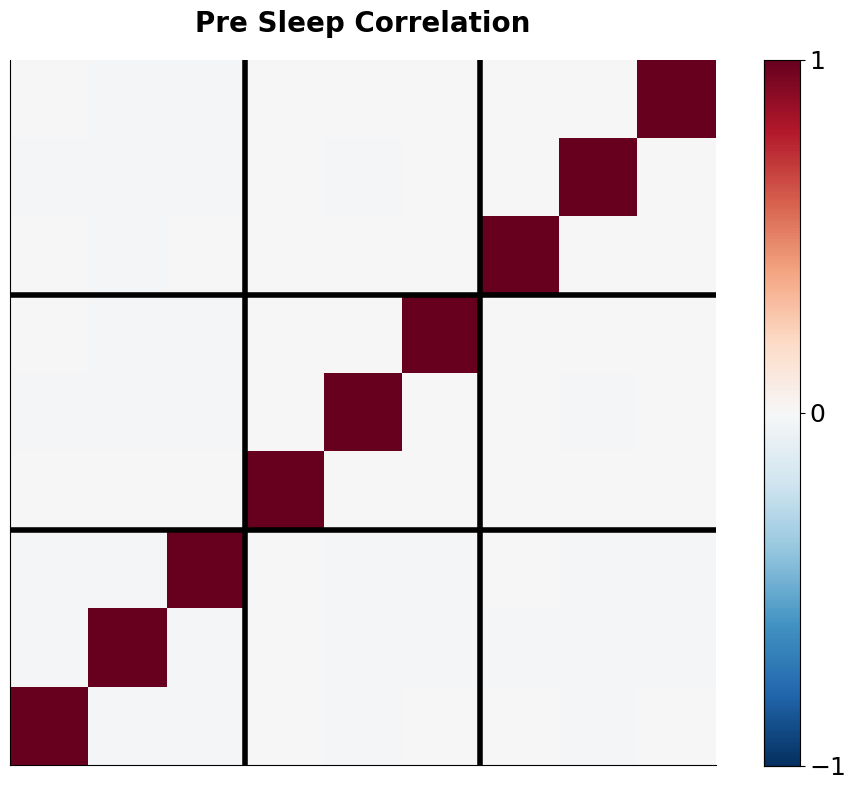

In [52]:
# Plot correlation matrix

# Set the limits of the colobar
min = -1
max = 1

# Set the figure size
fig, ax = plt.subplots(figsize=(10, 8))

img = plt.imshow(correlation_matrix, cmap='RdBu_r', interpolation='nearest', origin='lower')
ax.set_title('Pre Sleep Correlation', fontsize=20, weight='bold', pad=20)
ax.set_xticks([])
ax.set_yticks([])

# Add a colorbar with a label
cbar = plt.colorbar(img, ticks=[-1, 0, 1]) 

# Set font size for colorbar ticks
cbar.ax.tick_params(labelsize=18) 

# Set font size for colorbar ticks
cbar.ax.tick_params(labelsize=18) 

# Set the limits of the colorbar
plt.clim(vmin=min, vmax=max)

# Add dashed lines
dash_positions = [2.5, 5.5]  # Adjust these positions based on your requirements
for pos in dash_positions:
    plt.axhline(y=pos, color='black', linestyle='-', linewidth=4)
    plt.axvline(x=pos, color='black', linestyle='-', linewidth=4)

sns.despine()
plt.tight_layout()
plt.show()

## 4. Sleep phase

*"After the training stage, the sleep-like thalamo-cortical spontaneous slow oscillations activity is induced for a total duration of 600s by providing a non-specific Poisson noise inside the cortex (700 Hz) and increasing the strength of SFA parameter (b = 60, in eq. (1)). No external stimulus is provided to cells. Also, the synaptic weights between inhibitory and excitatory neurons in the cortex is reduced to -0.5. In this stage asymmetric STDP plasticity (alpha = 3.0) is active in the recurrent cx connectivity, inducing sleep-induced modification in the synaptic weights structure. The parameters’ change to obtain the slow oscillating regime were chosen relying on mean field theory framework18,19."* (Capone, C., Pastorelli, E., Golosio, B. et al. 2019)

Simulate sleep.

In [36]:
# Input sleep oscillation
#net.input_sleep()

In [37]:
# Run simulation
#nest.Simulate(5000.0)

Get results.

Cx population:

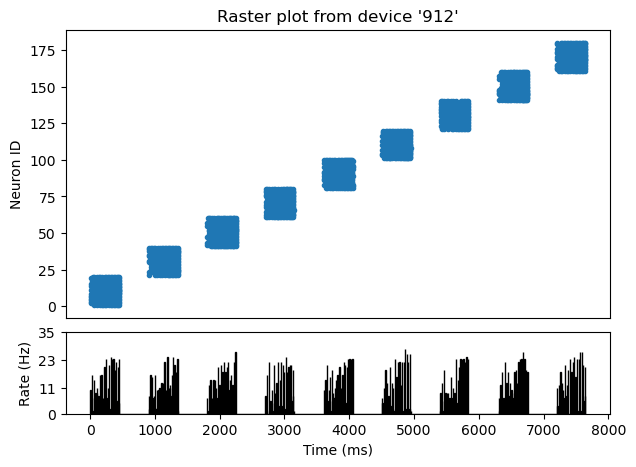

In [38]:
nest.raster_plot.from_device(net.spikes_cx, hist=True)

Tc population:

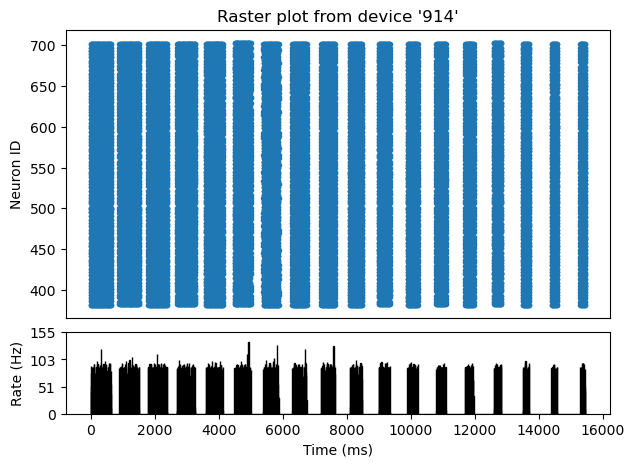

In [39]:
nest.raster_plot.from_device(net.spikes_tc, hist=True)

In population:

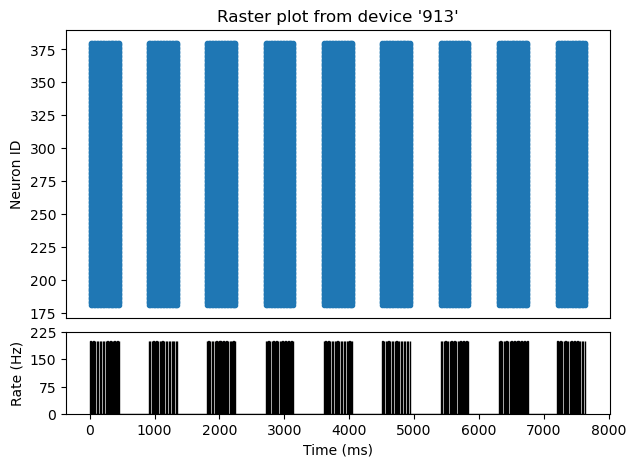

In [40]:
nest.raster_plot.from_device(net.spikes_in, hist=True)

Re population:

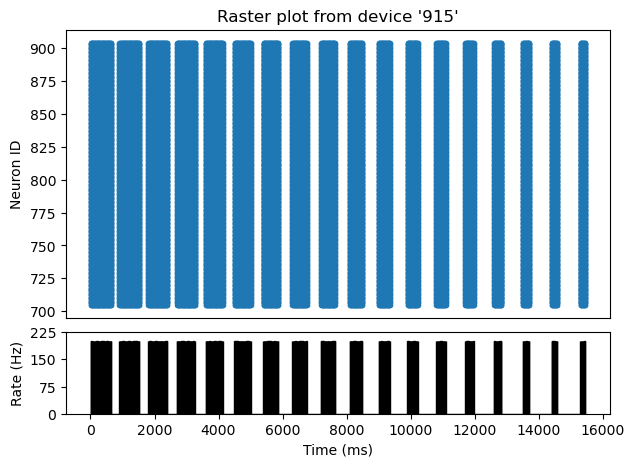

In [41]:
nest.raster_plot.from_device(net.spikes_re, hist=True)